In [1]:
import pandas as pd
import numpy as np
from config import PDF_FOLDER, embedding_manager
from ground_truth import data
from process_pdfs import load_tokenized_documents, tokenize_and_store, embedd_pdfs_and_save
from retrieval_methods import dense_retrieval, hybrid_retrieval, BM25_retrieval
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import csv
from chroma import vector_store_manager
from dictabert_deep_seek_answers import answers_dictabert
from xlm_roberta__deep_seek_answers import answers_xlm_roberta
from mpnet_base_v2_deep_seek_answers import answers_mpnet_base_v2
warnings.filterwarnings("ignore")

No sentence-transformers model found with name dicta-il/dictabert. Creating a new one with mean pooling.
Some weights of BertModel were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Ground truth refers to well-established answers or knowledge document chunks in a dataset corresponding to user queries. When the ground truth is the answers, we can directly compare the ground truth with the RAG responses, facilitating an end-to-end measurement.

This ground truth dataset was generated by chatGPT o1 (includes reasoning).

NOTE: In an ideal world, a human would generate this data, but I am on a time budget, so I decided to generate the data.

In [2]:
ground_truth_data = pd.DataFrame(data)

But, currently we are focusing only on the retrieval analysis, meaning we are more interested in the ground truth context than the answer.

In [3]:
context_performance_df = ground_truth_data.drop(columns=['answer', 'question_type'])
context_performance_df.head()

,relevant_pdf,question,context
0,383-2025.pdf,מהי הגישה העיקרית שמתוארת בתחום הנדסת מערכות?,הנדסת מערכות הנה גישה רב / בין תחומית ועקבית ל...
1,383-2025.pdf,מהן המטרות העיקריות של התוכנית להנדסת מערכות ב...,מטרות התוכנית להקנות ידע תיאורטי ומעשי בתחום ה...
2,383-2025.pdf,כיצד התוכנית בהנדסת מערכות מתייחסת לצרכים הטכנ...,הנדסת המערכת מתייחסת הן לצד העסקי והן לצרכים ה...
3,383-2025.pdf,איזו תרומה מספקת התוכנית לתעשיות בדרום הארץ?,בדרוםו בכלל לתת מענה לצרכים מובהקים של התעשיו...
4,383-2025.pdf,איזה כישורים מפתחת התוכנית כדי להכשיר מהנדסי מ...,התוכנית תכשיר את מהנדסי המערכות לשמש בארגונם ...


In [4]:
all_relevant_pdfs = set(context_performance_df['relevant_pdf'])
amount_of_pdfs = len(all_relevant_pdfs)

# Dense Retrievel

For dense retrieval, we will compare the following 3 models:

1. sentence-transformers/all-mpnet-base-v2 - A widely used embedding model, size - 109M params
2. FacebookAI/xlm-roberta-large - One of the most downloaded embedding models in Hugging Face, this model was trained on more than 100 languages, including hebrew, making it a good candidate, size - 561M params
3. dicta-il/dictabert - An embedding model specifically crafted for hebrew, size - 184M params

In [5]:
models_for_test = [
    "sentence-transformers/all-mpnet-base-v2",
    "FacebookAI/xlm-roberta-large",
    "dicta-il/dictabert"
]

In [6]:
# Run only if not saved already:
# for model in models_for_test:
#     vector_store_manager.update_embedding_model(model)
#     embedd_pdfs_and_save(PDF_FOLDER)

### Using the Ground Truth dataset, we run each question on each model, and retrieve the top 10 results.

In [7]:
tok_k_vector_similarity = 10

for model in models_for_test:
    dense_results = {}
    vector_store_manager.update_embedding_model(model)

    for i in context_performance_df.index:
        question = context_performance_df.loc[i]['question']
        dense_results[i] = dense_retrieval(query=question, top_k=tok_k_vector_similarity)

    context_performance_df['dense_results_' + embedding_manager.get_embedding_model_name()] = context_performance_df.index.map(dense_results)

No sentence-transformers model found with name FacebookAI/xlm-roberta-large. Creating a new one with mean pooling.
No sentence-transformers model found with name dicta-il/dictabert. Creating a new one with mean pooling.
Some weights of BertModel were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
context_performance_df.head()

,relevant_pdf,question,context,dense_results_sentence-transformers/all-mpnet-base-v2,dense_results_FacebookAI/xlm-roberta-large,dense_results_dicta-il/dictabert
0,383-2025.pdf,מהי הגישה העיקרית שמתוארת בתחום הנדסת מערכות?,הנדסת מערכות הנה גישה רב / בין תחומית ועקבית ל...,[(page_content=' מסלולי התמחות: תקשורת מידע וס...,"[(page_content='�ה בתחום התשתיות הלאומיות, לקר...",[(page_content='36214754 דינמיקה ואוירודינמיקה...
1,383-2025.pdf,מהן המטרות העיקריות של התוכנית להנדסת מערכות ב...,מטרות התוכנית להקנות ידע תיאורטי ומעשי בתחום ה...,[(page_content='ה\nואינטגרטיבית. המחלקה מעודדת...,[(page_content='ל צרכי הלקוח .\nהתוכנית להנדסת...,[(page_content='ר לתואר שני בהנדסה סביבתית\nתו...
2,383-2025.pdf,כיצד התוכנית בהנדסת מערכות מתייחסת לצרכים הטכנ...,הנדסת המערכת מתייחסת הן לצד העסקי והן לצרכים ה...,[(page_content='�ת התלמיד לקראת הבחינה. בתקופה...,"[(page_content='�ה בתחום התשתיות הלאומיות, לקר...",[(page_content=' ותיקוף המערכת ומתוך ראייה הבע...
3,383-2025.pdf,איזו תרומה מספקת התוכנית לתעשיות בדרום הארץ?,בדרוםו בכלל לתת מענה לצרכים מובהקים של התעשיו...,[(page_content='�ריית מידע בארץ ובעולם .\nתכני...,[(page_content='יתן להירשם לקורס בחירה מתוך רש...,[(page_content='ל צרכי הלקוח .\nהתוכנית להנדסת...
4,383-2025.pdf,איזה כישורים מפתחת התוכנית כדי להכשיר מהנדסי מ...,התוכנית תכשיר את מהנדסי המערכות לשמש בארגונם ...,[(page_content='היה לתלמיד מנחה מהמחלקה להנדסת...,[(page_content='� לחיזוק החינוך הטכנולוגי – מד...,[(page_content='� לחיזוק החינוך הטכנולוגי – מד...


In [9]:
models_performance = {}

for model in models_for_test:
    top_k_indexs = {}
    correct_pdf_scores = {}

    for i in context_performance_df.index:
        dense_results_in_row = context_performance_df.loc[i]['dense_results_' + model]

        dense_results_in_row = sorted(dense_results_in_row, key=lambda x: x[1], reverse=True)

        relevant_pdf_in_row = context_performance_df.loc[i]['relevant_pdf']

        top_k_index = []
        correct_pdf_score = []

        for j ,result in enumerate(dense_results_in_row):
            if result[0].metadata['source']==relevant_pdf_in_row:
                top_k_index.append(j + 1)
                correct_pdf_score.append(result[1])

        top_k_indexs[i] = top_k_index
        correct_pdf_scores[i] = correct_pdf_score


    performance = context_performance_df[['relevant_pdf']].copy()
    performance['correct_pdf_scores'] = performance.index.map(correct_pdf_scores)
    performance['top_k_indexs'] = performance.index.map(top_k_indexs)

    models_performance[model] = performance

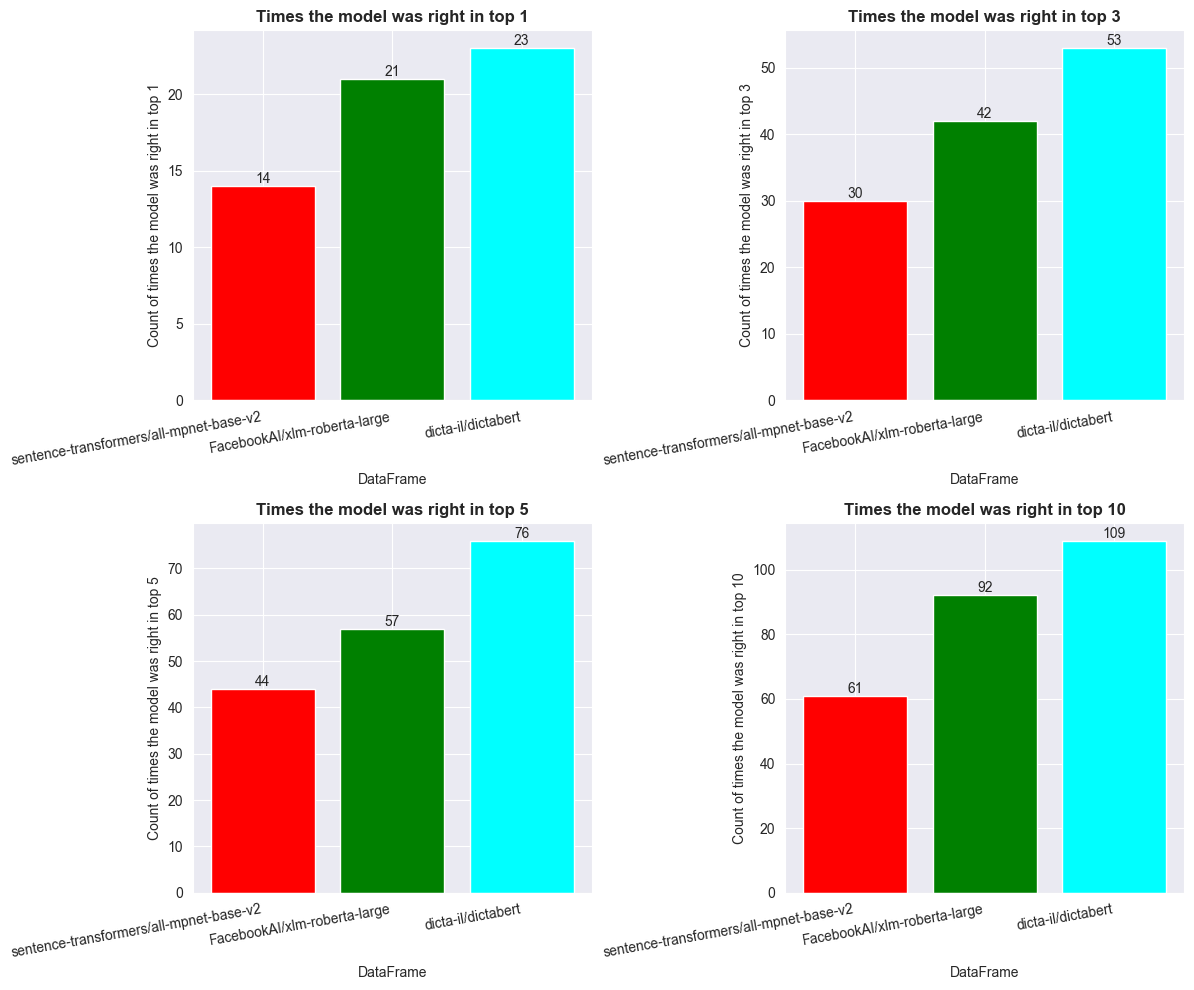

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
thresholds = [2, 4, 6, 11]

for ax, threshold in zip(axes.flatten(), thresholds):
    counts = {}
    for name, df in models_performance.items():
        counts[name] = sum(any(num < threshold for num in row) for row in df['top_k_indexs'])

    bars = ax.bar(counts.keys(), counts.values(), color=['red', 'green', 'cyan'])
    ax.set_xlabel("DataFrame")
    ax.set_ylabel(f"Count of times the model was right in top {threshold-1}")
    ax.set_title(f"Times the model was right in top {threshold-1}", fontweight='bold')
    ax.set_xticklabels(counts.keys(), rotation=10, ha='right')

    for bar in bars:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(bar.get_height()), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In the above plots, we check if the relevant document exists in the top k finds of the retrieved pdfs. For example, the relevant pdf is 361-2025 and the retrieval found that the 3rd document is from the relevant pdf, then we count that the model as right in the top 3 results. This metric is similar to Recall@K.

We can see that dicta-il/dictabert is leading by far, on all the plots, if we look at the top 10 finds, we can see that dicta-il/dictabert found a document in the relevant pdf 109/127 times. While sentence-transformers/all-mpnet-base-v2 finds were more then half the time (61/127) not in the relevant pdf. This metric might not be very accurate, because even if the model found a document in the relevant pdf that doesnt mean the document is related to the question, but its a good start!

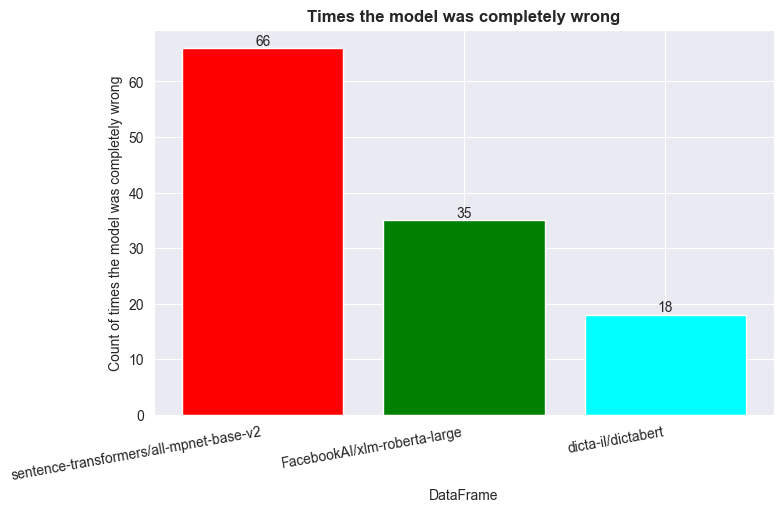

In [11]:
fig, ax = plt.subplots(figsize=(8, 5))

counts = {}
for name, df in models_performance.items():
    count = sum(1 for row in df['top_k_indexs'] if len(row) == 0)
    counts[name] = count

bars = ax.bar(counts.keys(), counts.values(), color=['red', 'green', 'cyan'])
ax.set_xlabel("DataFrame")
ax.set_ylabel("Count of times the model was completely wrong")
ax.set_title("Times the model was completely wrong", fontweight='bold')
ax.set_xticklabels(counts.keys(), rotation=10, ha='right')

for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(bar.get_height()), ha='center', va='bottom')

plt.show()

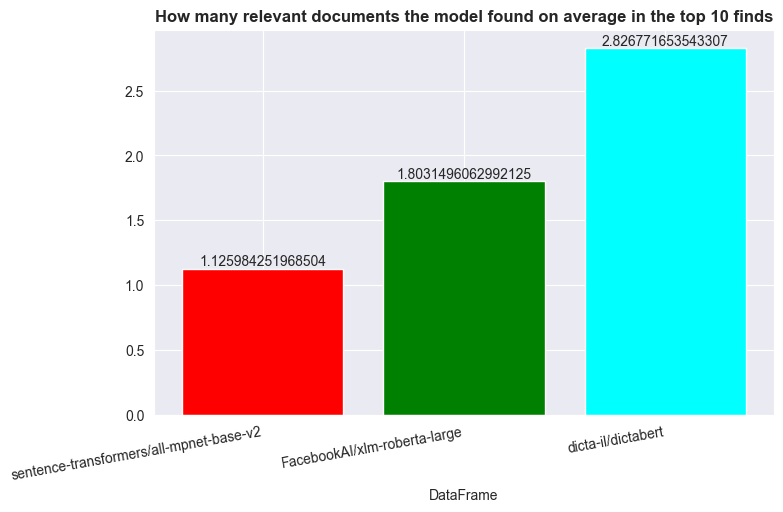

In [12]:
fig, ax = plt.subplots(figsize=(8, 5))

counts = {}
for name, df in models_performance.items():
    count = sum(len(row) for row in df['top_k_indexs'])
    counts[name] = count / df.shape[0]

bars = ax.bar(counts.keys(), counts.values(), color=['red', 'green', 'cyan'])
ax.set_xlabel("DataFrame")
ax.set_ylabel("")
ax.set_title("How many relevant documents the model found on average in the top 10 finds", fontweight='bold')
ax.set_xticklabels(counts.keys(), rotation=10, ha='right')

for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(bar.get_height()), ha='center', va='bottom')

plt.show()

A metric that is a little more interesting, is how many documents the model found of the relevant pdf? (For example, if a model found 5 documents that are from the relevant pdf from the top 10 finds, which is quiet good, then we find the average of that for every model). This is basically average Recall@K across all questions.

Here, dicta-il/dictabert is leading as well, with an average of almost 3, meaning, dicta-il/dictabert finds almost 3 documents on average in the relevant pdf. For comparison, sentence-transformers/all-mpnet-base-v2 finds only about 1 per 10 searches.

In [13]:
for model in models_for_test:
    df = models_performance[model]
    df['question'] = context_performance_df['question']
    relevant_documents_from_dense_retrieval = pd.Series()

    for i in df.index:
        right_top_k_indexs = df.loc[i]['top_k_indexs']
        relevant_documents = []
        for j in right_top_k_indexs:
            relevant_documents.append(context_performance_df.loc[i]['dense_results_' + models_for_test[2]][j-1][0])
        relevant_documents_from_dense_retrieval[i] = relevant_documents

    df['relevant_documents_from_dense_retrieval'] = relevant_documents_from_dense_retrieval

In [14]:
# Run only of not saved already:
# for model in models_for_test:
#     df = models_performance[model].copy()
#     df = df.drop(['top_k_indexs', 'correct_pdf_scores', 'relevant_pdf'], axis=1)
#     df.to_csv(model.replace('/', '-') + "_results" +".csv")

In an ideal world, to assess wether the context given by our dense retrieval is sufficing to answer the question, a human world go through each and every question and try answering it with the given context. But, I am a on a time budget, so I will use deepseek to help me. I am using deepseek r1 671B (the full version) parameters (with reasoning capabilities) and asking him to try answering the question based only on the given prompt, using a given csv containing only 2 features, "question" and "relevant_documents_from_dense_retrieval". I will provide deepseek with the following prompt:

You are assisting me in answering a csv of question, the said csv is attached. For each row in the csv, answer the queation in the row using only the context from relevant_documents_from_dense_retrieval feature in that row. If you cant get the answer from the context, simply say "I dont know". Return a dictionary in a code block where the key is the index of the row and the value is your answer. Each answer should be 3 sentences long at most and precise.

Because each csv exceeds deepseeks context window, I will divide the csvs into 4 sections and run this prompt on each of them, then combining the results.

NOTE - I know the answers might contain hallucinations or errors, but I am on a time budget and still want to see this metric

In [15]:
def split_csv_into_four(input_csv, out_csv_1, out_csv_2, out_csv_3, out_csv_4):
    with open(input_csv, 'r', encoding='utf-8') as f:
        reader = list(csv.reader(f))

    header = reader[0]
    data_rows = reader[1:]

    total_data_rows = len(data_rows)
    rows_per_part = total_data_rows // 4
    remainder = total_data_rows % 4

    def write_csv(output_csv, rows):
        with open(output_csv, 'w', newline='', encoding='utf-8') as out_f:
            writer = csv.writer(out_f)
            writer.writerow(header)
            writer.writerows(rows)

    part1 = data_rows[0 : rows_per_part]
    part2 = data_rows[rows_per_part : 2 * rows_per_part]
    part3 = data_rows[2 * rows_per_part : 3 * rows_per_part]
    part4 = data_rows[3 * rows_per_part : ]
    write_csv(out_csv_1, part1)
    write_csv(out_csv_2, part2)
    write_csv(out_csv_3, part3)
    write_csv(out_csv_4, part4)

In [16]:
# Run if not already saved:
# split_csv_into_four("./dictabert_results/dicta-il-dictabert_results.csv", "./dictabert_results/dicta-il-dictabert_results1.csv", "./dictabert_results/dicta-il-dictabert_results2.csv", "./dictabert_results/dicta-il-dictabert_results3.csv", "./dictabert_results/dicta-il-dictabert_results4.csv")
# split_csv_into_four("./xlm-roberta-large-results/FacebookAI-xlm-roberta-large_results.csv", "./xlm-roberta-large-results/FacebookAI-xlm-roberta-large_results1.csv", "./xlm-roberta-large-results/FacebookAI-xlm-roberta-large_results2.csv", "./xlm-roberta-large-results/FacebookAI-xlm-roberta-large_results3.csv", "./xlm-roberta-large-results/FacebookAI-xlm-roberta-large_results4.csv")
# split_csv_into_four("./mpnet_base_v2_results/sentence-transformers-all-mpnet-base-v2_results.csv", "./mpnet_base_v2_results/sentence-transformers-all-mpnet-base-v2_results1.csv", "./mpnet_base_v2_results/sentence-transformers-all-mpnet-base-v2_results2.csv", "./mpnet_base_v2_results/sentence-transformers-all-mpnet-base-v2_results3.csv", "./mpnet_base_v2_results/sentence-transformers-all-mpnet-base-v2_results4.csv")

In [17]:
def get_amount_of_successes(answers):
    return sum([0 if s.strip().lower() in {"איני יודע.","לא יודע","i dont know", "i don't know", "i dont know."} else 1 for s in list(answers.values())])

In [18]:
dictabert_success_amount = get_amount_of_successes(answers_dictabert)
xlm_roberta_success_amount = get_amount_of_successes(answers_xlm_roberta)
mpnet_base_v2_success_amount = get_amount_of_successes(answers_mpnet_base_v2)

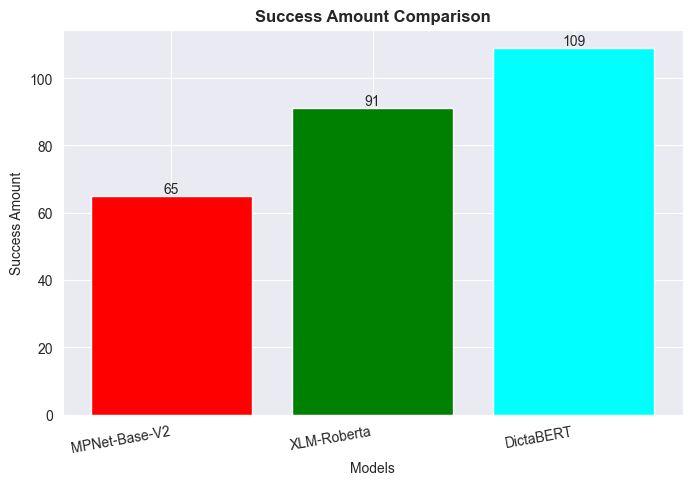

In [19]:
fig, ax = plt.subplots(figsize=(8, 5))

counts = {
    "MPNet-Base-V2": mpnet_base_v2_success_amount,
    "XLM-Roberta": xlm_roberta_success_amount,
    "DictaBERT": dictabert_success_amount
}

bars = ax.bar(counts.keys(), counts.values(), color=['red', 'green', 'cyan'])
ax.set_xlabel("Models")
ax.set_ylabel("Success Amount")
ax.set_title("Success Amount Comparison", fontweight='bold')
ax.set_xticklabels(counts.keys(), rotation=10, ha='right')

for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(bar.get_height()), ha='center', va='bottom')

plt.show()

Finally, we plot how many the documents provided sufficient information for the questions.

This is the most interesting metric, because it shows if the data retrieved was actually also relevant for the question.

Here, once again, we see DictaBert leading by far on the rest of the model. So we will use DictaBERT as an embedding model.

# BM25 results analysis:

### We tokenize the all of the pdfs, using a simple tokenizer, no preprocessing or cleaning.

In [20]:
# Run this if not already tokenized
# tokenize_and_store(PDF_FOLDER=PDF_FOLDER, clean_text=False)
tokenized_documents_not_clean = load_tokenized_documents(clean_text=False)

Loaded precomputed tokenized data from tokenized_pdfs_not_clean.pkl


# Retrieving context from BM25 retrieval method:

In [21]:
BM25_results = {}

for i in context_performance_df.index:
    question = context_performance_df.loc[i]['question']
    BM25_results[i] = BM25_retrieval(query=question, tokenized_documents=tokenized_documents_not_clean, top_k=amount_of_pdfs, clean_text=False)

context_performance_df['BM25_results'] = context_performance_df.index.map(BM25_results)

In [22]:
context_performance_df.head()

,relevant_pdf,question,context,dense_results_sentence-transformers/all-mpnet-base-v2,dense_results_FacebookAI/xlm-roberta-large,dense_results_dicta-il/dictabert,BM25_results
0,383-2025.pdf,מהי הגישה העיקרית שמתוארת בתחום הנדסת מערכות?,הנדסת מערכות הנה גישה רב / בין תחומית ועקבית ל...,[(page_content=' מסלולי התמחות: תקשורת מידע וס...,"[(page_content='�ה בתחום התשתיות הלאומיות, לקר...",[(page_content='36214754 דינמיקה ואוירודינמיקה...,"{'372-2025.pdf': 5.094810003404671, '361-2025...."
1,383-2025.pdf,מהן המטרות העיקריות של התוכנית להנדסת מערכות ב...,מטרות התוכנית להקנות ידע תיאורטי ומעשי בתחום ה...,[(page_content='ה\nואינטגרטיבית. המחלקה מעודדת...,[(page_content='ל צרכי הלקוח .\nהתוכנית להנדסת...,[(page_content='ר לתואר שני בהנדסה סביבתית\nתו...,"{'372-2025.pdf': 8.714424668147686, '383-2025...."
2,383-2025.pdf,כיצד התוכנית בהנדסת מערכות מתייחסת לצרכים הטכנ...,הנדסת המערכת מתייחסת הן לצד העסקי והן לצרכים ה...,[(page_content='�ת התלמיד לקראת הבחינה. בתקופה...,"[(page_content='�ה בתחום התשתיות הלאומיות, לקר...",[(page_content=' ותיקוף המערכת ומתוך ראייה הבע...,"{'383-2025.pdf': 17.26807091767017, '367-2025...."
3,383-2025.pdf,איזו תרומה מספקת התוכנית לתעשיות בדרום הארץ?,בדרוםו בכלל לתת מענה לצרכים מובהקים של התעשיו...,[(page_content='�ריית מידע בארץ ובעולם .\nתכני...,[(page_content='יתן להירשם לקורס בחירה מתוך רש...,[(page_content='ל צרכי הלקוח .\nהתוכנית להנדסת...,"{'383-2025.pdf': 6.961203307189391, '374-2025...."
4,383-2025.pdf,איזה כישורים מפתחת התוכנית כדי להכשיר מהנדסי מ...,התוכנית תכשיר את מהנדסי המערכות לשמש בארגונם ...,[(page_content='היה לתלמיד מנחה מהמחלקה להנדסת...,[(page_content='� לחיזוק החינוך הטכנולוגי – מד...,[(page_content='� לחיזוק החינוך הטכנולוגי – מד...,"{'383-2025.pdf': 12.44204576252839, '372-2025...."


In my BM25 retrieval function, I use BM25 on the entire pdf.
I use this tactic for the hybrid retrival method, which I will later explain more about.

In [23]:
def get_rank_of_key(data_dict, key):
    sorted_keys = sorted(data_dict, key=data_dict.get, reverse=True)

    rank = sorted_keys.index(key)

    return rank

In [24]:
top_k_index = {}
correct_pdf_score = {}
average_pdf_score_not_clean = dict.fromkeys(all_relevant_pdfs, 0)

for i in context_performance_df.index:
    BM_25_result_in_row = context_performance_df.loc[i]['BM25_results']
    relevant_pdf_in_row = context_performance_df.loc[i]['relevant_pdf']
    correct_pdf_score[i] = BM_25_result_in_row[relevant_pdf_in_row]
    top_k_index[i] = get_rank_of_key(BM_25_result_in_row, relevant_pdf_in_row)+1
    average_pdf_score_not_clean[relevant_pdf_in_row] += correct_pdf_score[i]

average_pdf_score_not_clean= {key: value / amount_of_pdfs for key, value in average_pdf_score_not_clean.items()}
BM25_pdf_scores_not_clean = context_performance_df[['relevant_pdf']].copy()
BM25_pdf_scores_not_clean['correct_pdf_score'] = BM25_pdf_scores_not_clean.index.map(correct_pdf_score)
BM25_pdf_scores_not_clean['top_k_index'] = BM25_pdf_scores_not_clean.index.map(top_k_index)

## BM25_pdf_scores columns explanation:
1. relevant_pdf refers to the pdf that contains the context most relevant for the question thats being asked. For example, if my question is about Chemistry, the relevant_pdf will be 363-2025.pdf (the Chemistry department pdf)
2. correct_pdf_score refers to the score BM25 gave to that entire pdf.
3. top_k_index refers to the rank of the score compared to other pdfs, for example, if the correct pdf was ranked number 3 by BM25 score compared to other pdfs, then top_k_index will be equal to 3.

In [25]:
BM25_pdf_scores_not_clean.head()

,relevant_pdf,correct_pdf_score,top_k_index
0,383-2025.pdf,2.976639,3
1,383-2025.pdf,7.953741,2
2,383-2025.pdf,17.268071,1
3,383-2025.pdf,6.961203,1
4,383-2025.pdf,12.442046,1


In [26]:
BM25_pdf_scores_not_clean[BM25_pdf_scores_not_clean["top_k_index"]<5]['correct_pdf_score'].describe()

count    97.000000
mean      7.283964
std       2.755032
min       2.402305
25%       5.106942
50%       6.961203
75%       9.118735
max      17.268071
Name: correct_pdf_score, dtype: float64

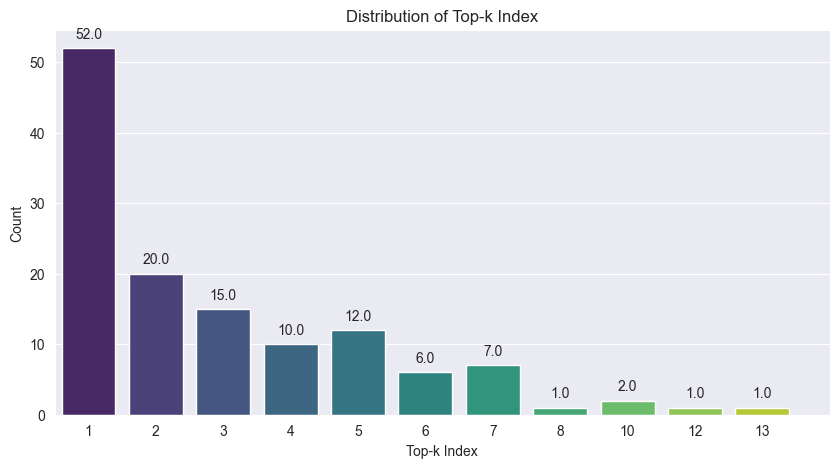

In [27]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=BM25_pdf_scores_not_clean['top_k_index'], palette='viridis')
plt.xlabel('Top-k Index')
plt.ylabel('Count')
plt.title('Distribution of Top-k Index')
plt.xticks(range(0, 12))

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}',
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom',
                xytext=(0, 5), textcoords='offset points')

plt.show()

It seems like BM25 is doing a descent job, recognizing the most relevant pdf 52 times out of 130.

Lets try cleaning and preprocessing our pdfs and query before tokenizing and retrieving, this is the cleaning steps we use:

1. Remove punctuations
2. Remove any english characters that are in any pdf by mistake
3. Remove extra redundant characters like '/n' and '/t'
4. Remove stop words from a given list I found online
5. Finally, we remove redundant spaces that PDFPlumber generates (לפעמים הוא מייצר רווחים לאות האחרונה של המילה, כלומר הוא יחזיר "כלל י " במקום "כללי")

In [28]:
# Run if not already saved
# tokenize_and_store(PDF_FOLDER=PDF_FOLDER, clean_text=True)
tokenized_documents_clean = load_tokenized_documents(clean_text=True)

Loaded precomputed tokenized data from tokenized_pdfs_clean.pkl


In [29]:
BM25_results = {}

tok_k_vector_similarity = 5
top_k_BM25 = 3

for i in context_performance_df.index:
    question = context_performance_df.loc[i]['question']
    BM25_results[i] = BM25_retrieval(query=question, tokenized_documents=tokenized_documents_clean, top_k=amount_of_pdfs, clean_text=True)

context_performance_df['BM25_results'] = context_performance_df.index.map(BM25_results)

In [30]:
top_k_index = {}
correct_pdf_score = {}
average_pdf_score_clean = dict.fromkeys(all_relevant_pdfs, 0)

for i in context_performance_df.index:
    BM_25_result_in_row = context_performance_df.loc[i]['BM25_results']
    relevant_pdf_in_row = context_performance_df.loc[i]['relevant_pdf']
    correct_pdf_score[i] = BM_25_result_in_row[relevant_pdf_in_row]
    top_k_index[i] = get_rank_of_key(BM_25_result_in_row, relevant_pdf_in_row)+1
    average_pdf_score_clean[relevant_pdf_in_row] += correct_pdf_score[i]

average_pdf_score_clean= {key: value / amount_of_pdfs for key, value in average_pdf_score_clean.items()}
BM25_pdf_scores_clean = context_performance_df[['relevant_pdf']].copy()
BM25_pdf_scores_clean['correct_pdf_score'] = BM25_pdf_scores_clean.index.map(correct_pdf_score)
BM25_pdf_scores_clean['top_k_index'] = BM25_pdf_scores_clean.index.map(top_k_index)

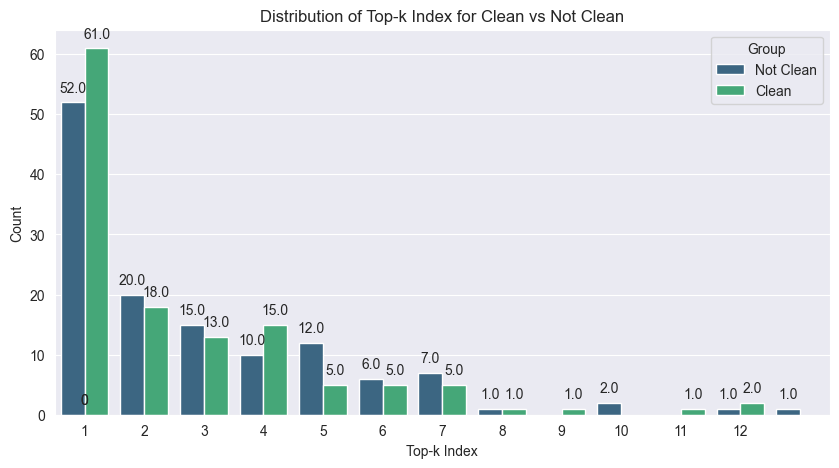

In [31]:
df_not_clean = BM25_pdf_scores_not_clean.copy()
df_not_clean['Group'] = 'Not Clean'

df_clean = BM25_pdf_scores_clean.copy()
df_clean['Group'] = 'Clean'

df_combined = pd.concat([df_not_clean, df_clean])

plt.figure(figsize=(10, 5))
ax = sns.countplot(x='top_k_index', hue='Group', data=df_combined, palette='viridis')
plt.xlabel('Top-k Index')
plt.ylabel('Count')
plt.title('Distribution of Top-k Index for Clean vs Not Clean')
plt.xticks(range(0, 12))

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}',
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom',
                xytext=(0, 5), textcoords='offset points')

plt.show()

Putting the results side by side, we can see a big improvement on the most relevant PDF.

It looks like BM25 is doing an amazing job half the time, recognizing almost half of the relevant pdfs perfectly. Furthermore, its clear that after top_k_index 7 there are almost no relevant pdfs, suggesting the optimized parameter for retrieving top_k elements by BM25 should be 7.

# Hybrid Retrieval Results:

For our hybrid retrieval method we use the following method:
We saw in our BM25 analysis that 96% of all pdfs retrieved fall in the top 7 zone, so we do a BM25 search getting the top 7 source documents. We then do dense retrival, with a filter to retrieve only from those top 7 documents.

This time we won't check any other models, because we already showed that dicta-il/dictabert is the best one for our task

In [32]:
tok_k_vector_similarity = 10
top_k_BM25 = 7
model = 'dicta-il/dictabert'

hybrid_results = {}
vector_store_manager.update_embedding_model(model)

for i in context_performance_df.index:
    question = context_performance_df.loc[i]['question']
    hybrid_results[i] = hybrid_retrieval(query=question, tokenized_documents=tokenized_documents_clean, top_k_BM25=top_k_BM25, tok_k_vector_similarity = tok_k_vector_similarity)

    context_performance_df['hybrid_results_' + embedding_manager.get_embedding_model_name()] = context_performance_df.index.map(hybrid_results)

No sentence-transformers model found with name dicta-il/dictabert. Creating a new one with mean pooling.
Some weights of BertModel were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
top_k_indexs = {}
correct_pdf_scores = {}

for i in context_performance_df.index:
    dense_results_in_row = context_performance_df.loc[i]['hybrid_results_' + model]

    dense_results_in_row = sorted(dense_results_in_row, key=lambda x: x[1], reverse=True)

    relevant_pdf_in_row = context_performance_df.loc[i]['relevant_pdf']

    top_k_index = []
    correct_pdf_score = []

    for j ,result in enumerate(dense_results_in_row):
        if result[0].metadata['source']==relevant_pdf_in_row:
            top_k_index.append(j + 1)
            correct_pdf_score.append(result[1])

    top_k_indexs[i] = top_k_index
    correct_pdf_scores[i] = correct_pdf_score


hybrid_performance = context_performance_df[['relevant_pdf']].copy()
hybrid_performance['correct_pdf_scores'] = hybrid_performance.index.map(correct_pdf_scores)
hybrid_performance['top_k_indexs'] = hybrid_performance.index.map(top_k_indexs)

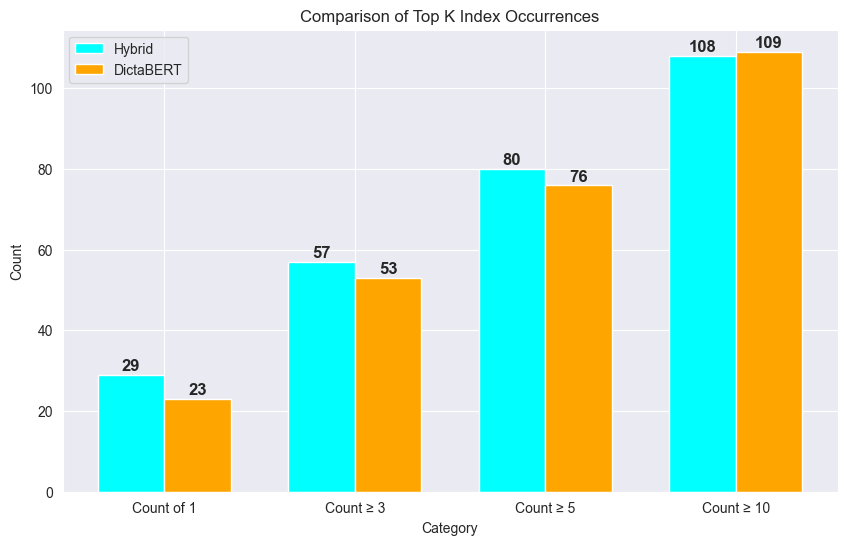

In [34]:
counts_hybrid = [
    sum(1 for row in hybrid_performance['top_k_indexs'] if 1 in row),
    sum(1 for row in hybrid_performance['top_k_indexs'] if any(x <= 3 for x in row)),
    sum(1 for row in hybrid_performance['top_k_indexs'] if any(x <= 5 for x in row)),
    sum(1 for row in hybrid_performance['top_k_indexs'] if any(x <= 10 for x in row))
]

dense_results_dictabert = models_performance['dicta-il/dictabert']
counts_dictabert = [
    sum(1 for row in dense_results_dictabert['top_k_indexs'] if 1 in row),
    sum(1 for row in dense_results_dictabert['top_k_indexs'] if any(x <= 3 for x in row)),
    sum(1 for row in dense_results_dictabert['top_k_indexs'] if any(x <= 5 for x in row)),
    sum(1 for row in dense_results_dictabert['top_k_indexs'] if any(x <= 10 for x in row))
]

labels = ['Count of 1', 'Count ≥ 3', 'Count ≥ 5', 'Count ≥ 10']
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10, 6))
bars1 = plt.bar(x - width/2, counts_hybrid, width, label='Hybrid', color='cyan')
bars2 = plt.bar(x + width/2, counts_dictabert, width, label='DictaBERT', color='orange')

for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, str(yval), ha='center', fontsize=12, fontweight='bold')

plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Comparison of Top K Index Occurrences')
plt.xticks(ticks=x, labels=labels)
plt.legend()

plt.show()

In [35]:
average_amount_of_context_using_hybrid = sum(len(row) for row in hybrid_performance['top_k_indexs'])/hybrid_performance.shape[0]
average_amount_of_context_dense = sum(len(row) for row in dense_results_dictabert['top_k_indexs'])/hybrid_performance.shape[0]
increase_percentage = ((average_amount_of_context_using_hybrid/average_amount_of_context_dense) - 1) * 100
print(f"Average amount of context from the relevant pdf using hybrid retrieval: {average_amount_of_context_using_hybrid}")
print(f"Average amount of context from the relevant pdf using dense retrieval: {average_amount_of_context_dense}")
print(f"Increase by {increase_percentage}%")

Average amount of context from the relevant pdf using hybrid retrieval: 3.094488188976378
Average amount of context from the relevant pdf using dense retrieval: 2.826771653543307
Increase by 9.47075208913648%


Like before, the top k index is a metric that shows if the retrieval method found a document that came from the relevant pdf containing the answer to the question asked.

We can see that the hybrid retrieval finds more documents that came from the relevant pdf for top 1, top 3 and top 5. For top 10 we can see a slight decrease by 1, which is negligible. We do see a nice increase in the average amount of documents from the relevant pdf in the top 10 finds, an increase of almost 10%, this is quite good because it might give the model the information needed to answer the question, while also deacreasing noise.

# In conclusion, we can see that combining retrieval method is better then using each alone.